## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import importlib
import lanes
%matplotlib inline
importlib.reload(lanes)

<module 'lanes' from '/Users/neo/Workspace/carnd/CarND-Advanced-Lane-Lines/lanes.py'>

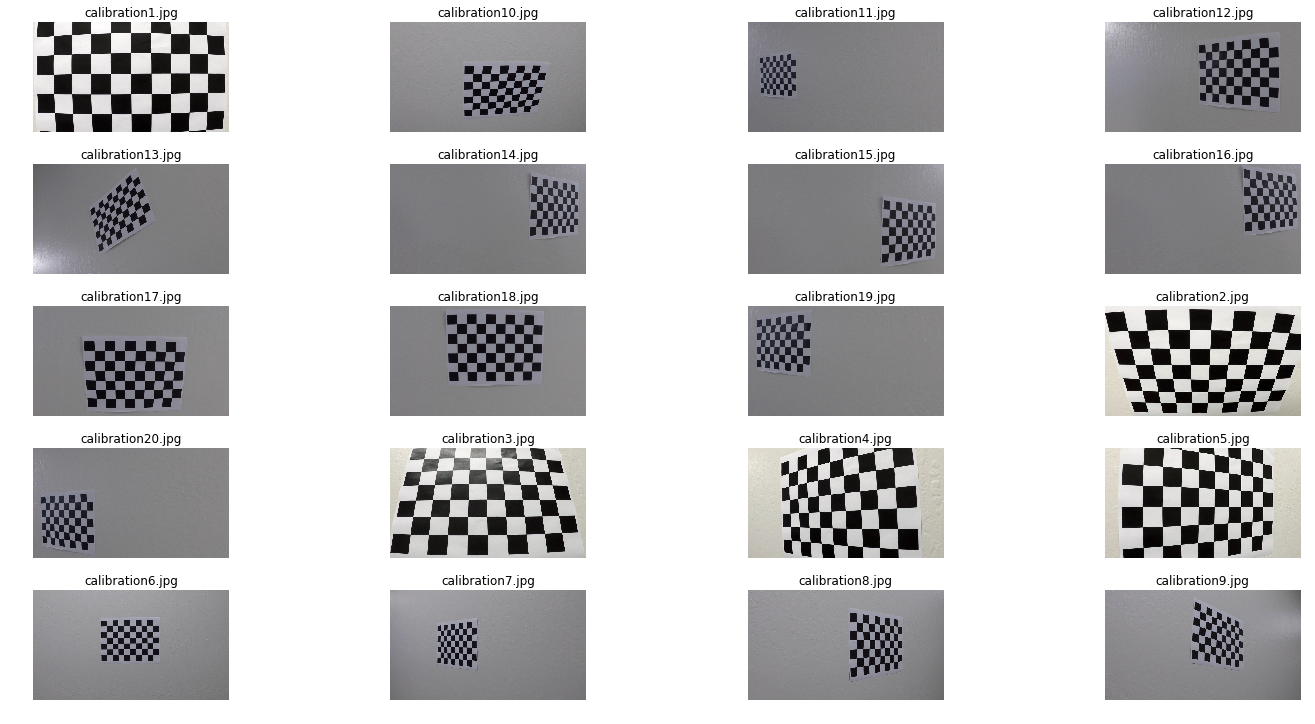

In [2]:
cal_files = glob.glob('camera_cal/calibration*.jpg')
cal_images = [mpimg.imread(cal_file) for cal_file in cal_files]

lanes.draw_images(cal_images,cal_files)

In [3]:
distortion = lanes.Distortion((9,6))
distortion.train(cal_images)

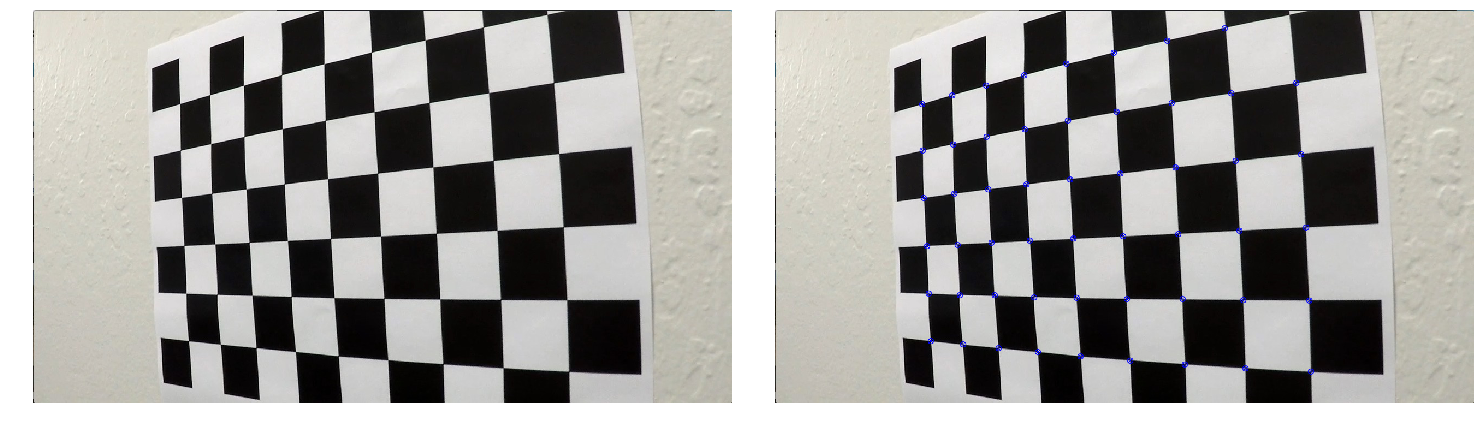

In [4]:
calibration4 = mpimg.imread('camera_cal/calibration4.jpg')
calibration4_with_chessboard = distortion.draw_chessboard(calibration4)
lanes.draw_2_images(calibration4, calibration4_with_chessboard)

## Undistort images

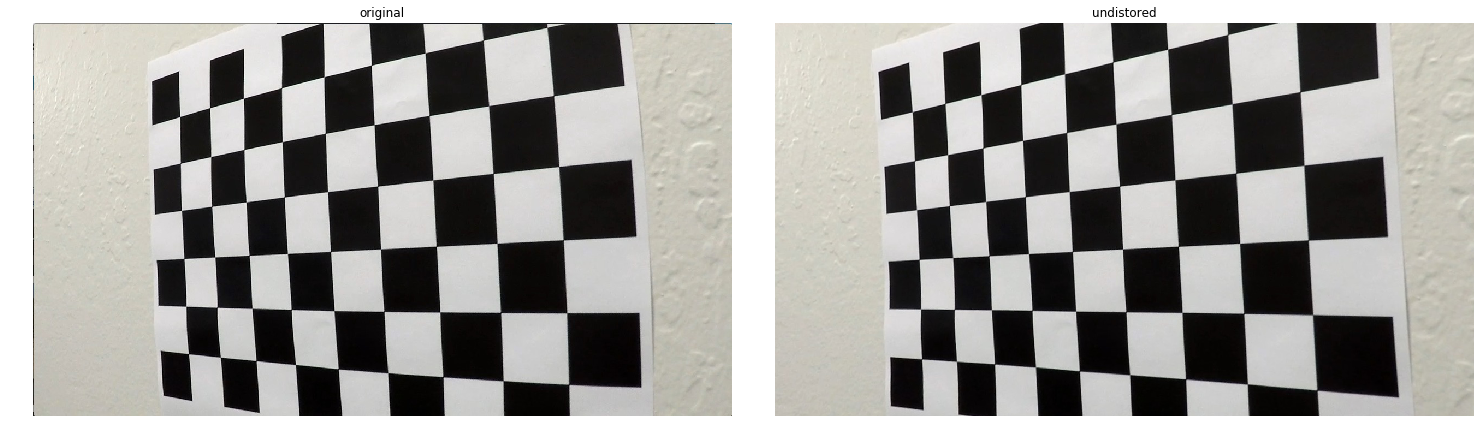

In [5]:
calibration4_undistorted = distortion.undistort(calibration4)
lanes.write_image('output_images/calibration4_undistorted.jpg', calibration4_undistorted)
lanes.draw_2_images(calibration4, calibration4_undistorted, left_image_title='original', right_image_title='undistored')

## Distort test image

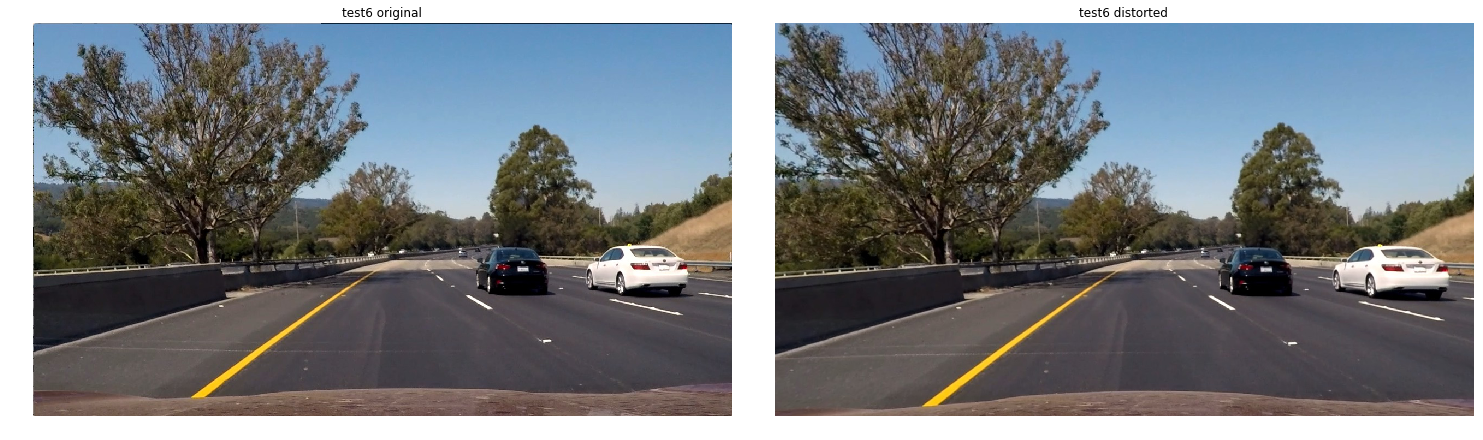

In [6]:
test_image = mpimg.imread('test_images/test6.jpg')
test_image_undistorted = distortion.undistort(test_image)
lanes.write_image('output_images/test6_distorted.jpg', test_image_undistorted)

lanes.draw_2_images(test_image, test_image_undistorted, left_image_title='test6 original', right_image_title='test6 distorted')

## Distort a staight line

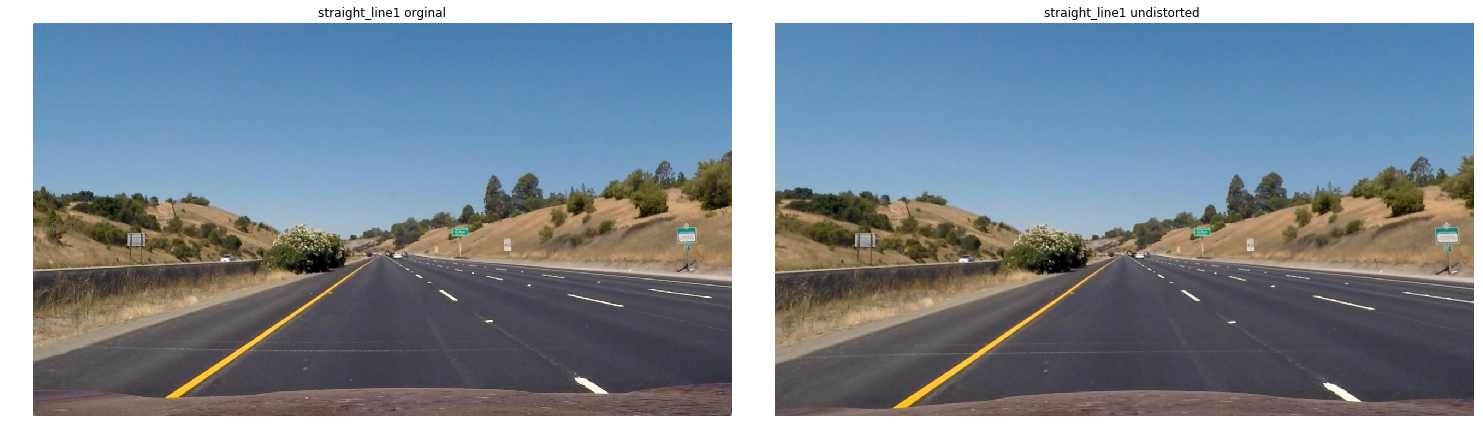

In [7]:
straight_line1 = mpimg.imread('test_images/straight_lines1.jpg')
straight_line1_undistorted = distortion.undistort(straight_line1)
lanes.write_image('output_images/straight_lines1_undistorted.jpg', straight_line1_undistorted)

lanes.draw_2_images(straight_line1, straight_line1_undistorted, 'straight_line1 orginal', 'straight_line1 undistorted ')

## Perspective transform
Let's do a perspective transform of the above image to get bird view.
First, I need to select 4 points in the undistored image using image procrossing tools to get point positions. The selected point positions are saved in the PerspectiveTransformer class

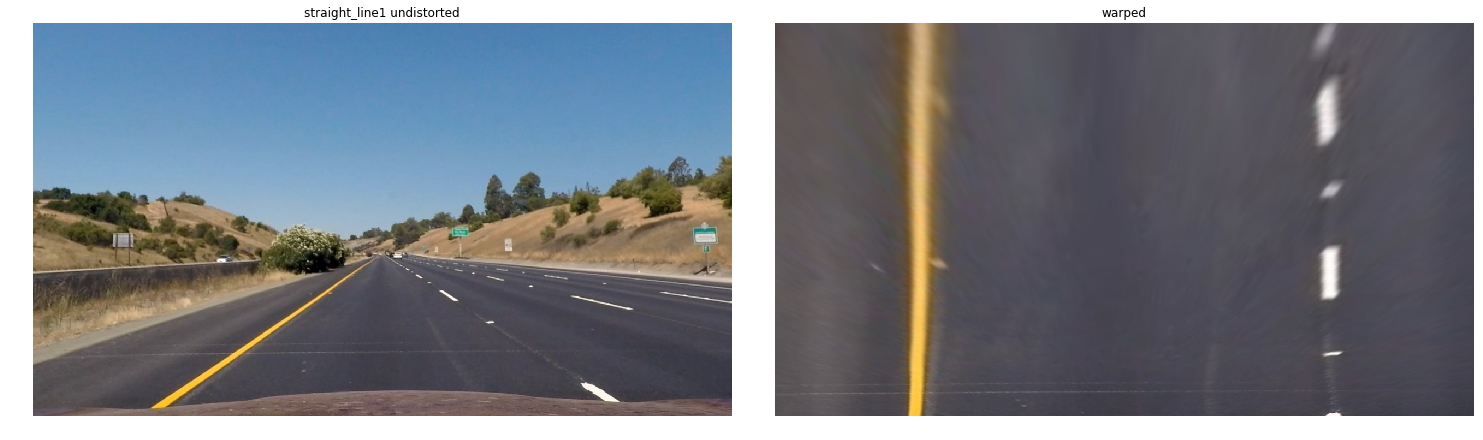

In [8]:
transformer = lanes.PerspectiveTransformer()
straight_line1_warped = transformer.transform(straight_line1_undistorted)
lanes.write_image('output_images/straight_lines1_warped.jpg', straight_line1_warped)

lanes.draw_2_images(straight_line1_undistorted, straight_line1_warped, 'straight_line1 undistorted', 'warped')

## Try test6 to see curved line warped

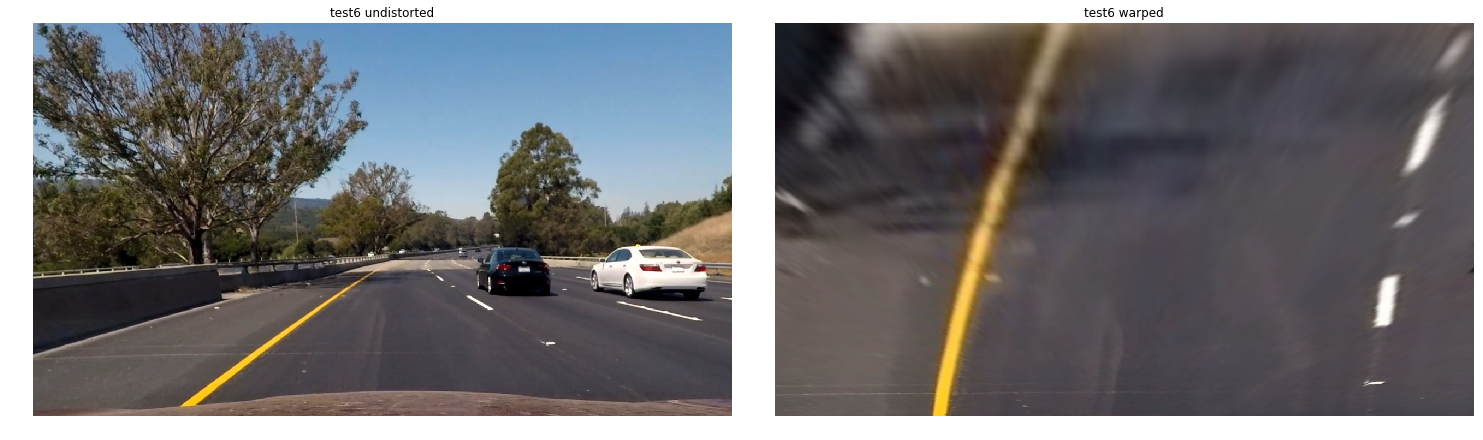

In [9]:
test_image_warped = transformer.transform(test_image_undistorted)
lanes.write_image('output_images/test6_warped.jpg', test_image_warped)

lanes.draw_2_images(test_image_undistorted, test_image_warped ,'test6 undistorted', 'test6 warped')

## Convert to threshold binary image
First do color threshold and sobelx threshold separately

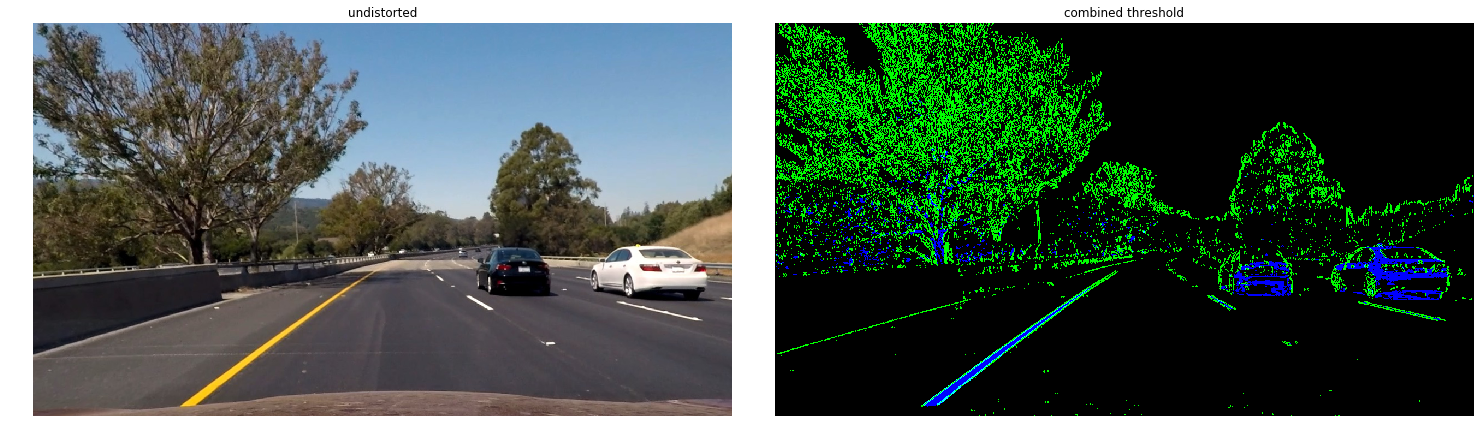

In [10]:
thresholdBinary = lanes.ThresholdBinary()

zeros = thresholdBinary.zeros(test_image_undistorted) 
gray_threshold = thresholdBinary.gray_threshold(test_image_undistorted)
saturation_threshold = thresholdBinary.saturation_threshold(test_image_undistorted)

combined = np.dstack([zeros, gray_threshold, saturation_threshold])

lanes.draw_2_images(test_image_undistorted, combined, 'undistorted', 'combined threshold')

Try test5 image to verify threshold binary

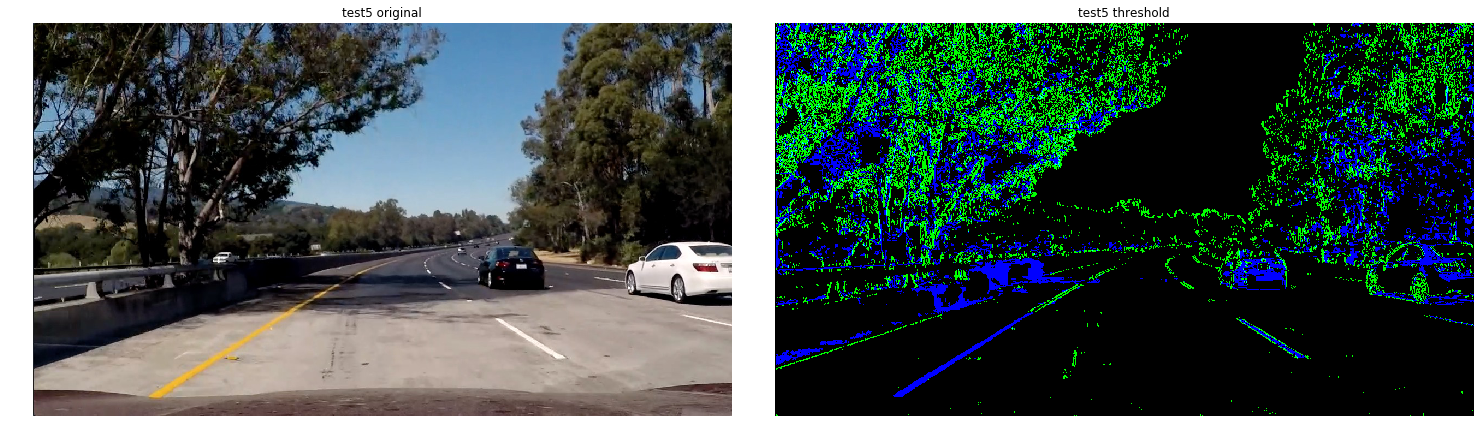

In [11]:
test5 = mpimg.imread('test_images/test5.jpg')
zeros = thresholdBinary.zeros(test5)
gray_threshold = thresholdBinary.gray_threshold(test5)
saturation_threshold = thresholdBinary.saturation_threshold(test5)

combined = np.dstack([zeros, gray_threshold, saturation_threshold])
lanes.write_image('output_images/test5_combined_separate.jpg',combined)

lanes.draw_2_images(test5, combined, 'test5 original', 'test5 threshold')

The above image looks like the image learned in the class, I can verify that the threshold is right.

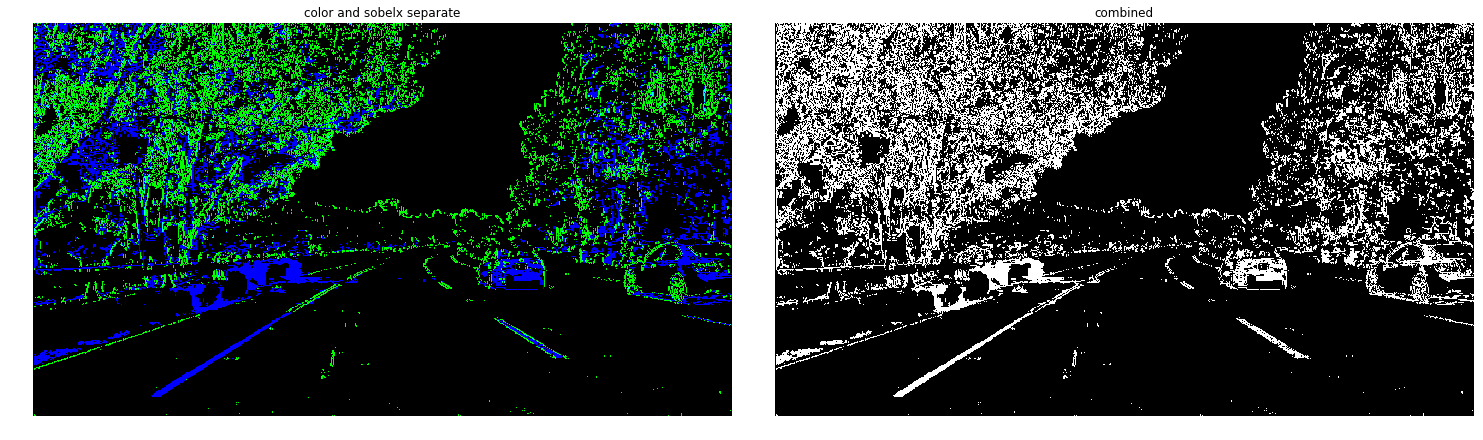

In [12]:
test5_combined = thresholdBinary.combined_threshold(test5)
lanes.write_image('output_images/test5_combined.jpg', test5_combined )

lanes.draw_2_images(combined,test5_combined,'color and sobelx separate', 'combined', right_gray=True)

## Do perspective transform to get bird view

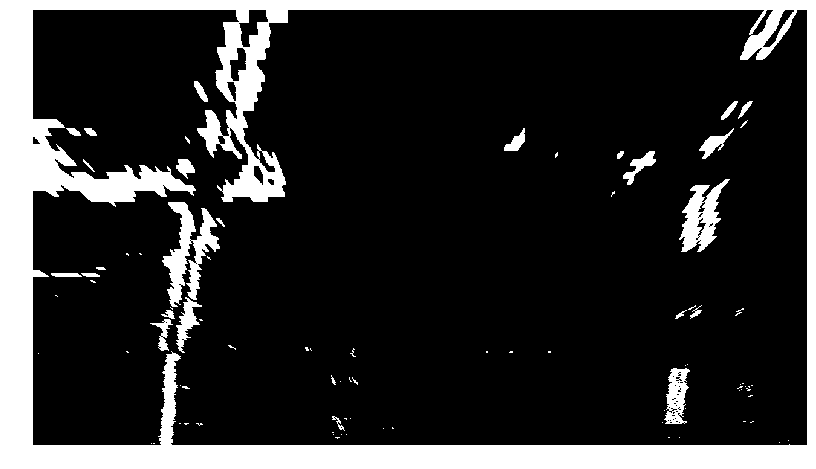

In [13]:
test5_combined_warped = transformer.transform(test5_combined)
lanes.write_image('output_images/test5_combined_warped.jpg', test5_combined_warped)

lanes.draw_image(test5_combined_warped, gray=True)

## Plot the histgram of the top half binary image

/Users/neo/.pyenv/versions/miniconda3-latest/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


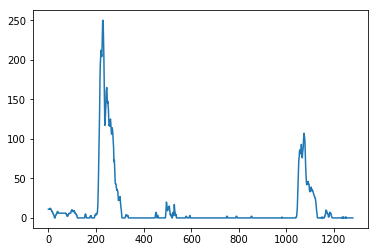

In [14]:
histogram = np.sum(test5_combined_warped[test5_combined_warped.shape[0]/2:,:], axis=0)
plt.plot(histogram)

## Using sliding window methods to find the polyfit

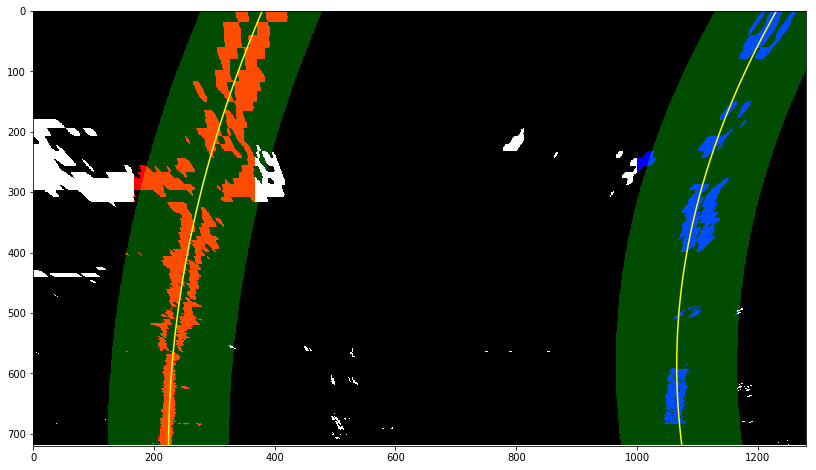

In [15]:
lane_finder = lanes.PolynomialFinder()
lane_finder.find_and_draw(test5_combined_warped)

## Make a pipeline to do all the work and add the lane marker result

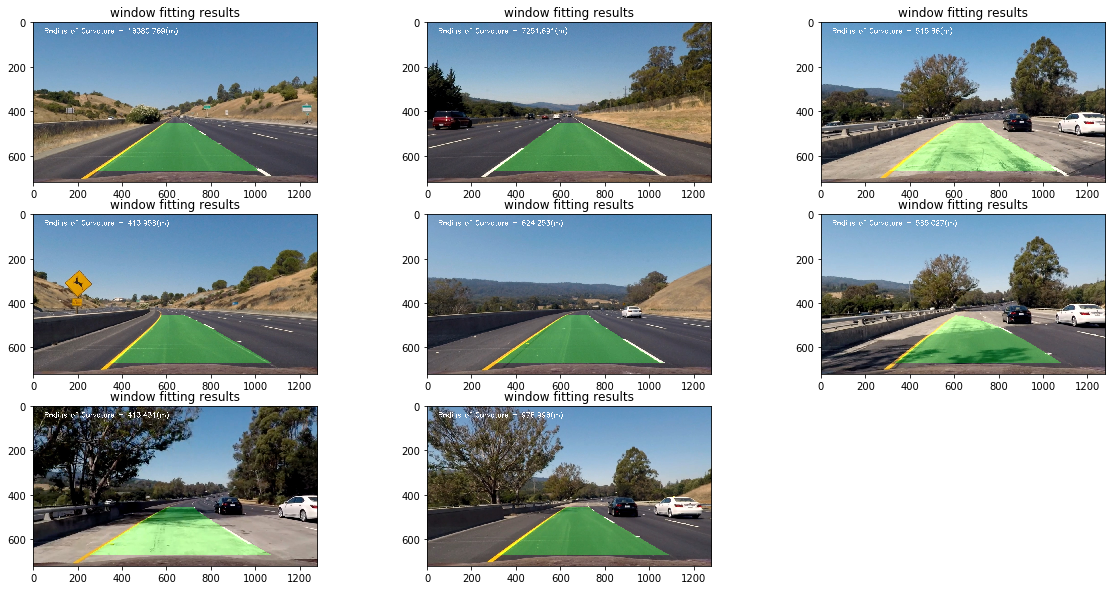

In [27]:
plt.figure(figsize=(20,10))
i = 1
offset=200
for filename in glob.glob('test_images/*.jpg'):
    pipeline = lanes.Pipeline()
    pipeline.calibrate_camera(cal_images)
    result = pipeline.do(mpimg.imread(filename))
    plt.subplot(3, 3, i)

    i += 1
    plt.imshow(result)
    plt.title('window fitting results')
plt.show()

## Now apply the pipeline to video

In [34]:
from moviepy.editor import *
pipeline = lanes.Pipeline()
pipeline.calibrate_camera(cal_images)
clip = VideoFileClip('project_video.mp4')
output = clip.fl_image(lambda x: pipeline.do(x))
output.write_videofile('output_track1.mp4')

[MoviePy] >>>> Building video output_track1.mp4
[MoviePy] Writing audio in output_track1TEMP_MPY_wvf_snd.mp3





  0%|          | 0/1112 [00:00<?, ?it/s]


 11%|█▏        | 126/1112 [00:00<00:00, 1255.14it/s]


 23%|██▎       | 255/1112 [00:00<00:00, 1253.61it/s]


 30%|███       | 335/1112 [00:00<00:00, 1070.48it/s]


 42%|████▏     | 465/1112 [00:00<00:00, 1129.46it/s]


 56%|█████▌    | 618/1112 [00:00<00:00, 1225.16it/s]


 71%|███████   | 789/1112 [00:00<00:00, 1335.66it/s]


 82%|████████▏ | 915/1112 [00:00<00:00, 1102.56it/s]


 95%|█████████▍| 1054/1112 [00:00<00:00, 1174.75it/s]


100%|██████████| 1112/1112 [00:00<00:00, 1243.79it/s]

[MoviePy] Done.
[MoviePy] Writing video output_track1.mp4





  0%|          | 0/1261 [00:00<?, ?it/s]


  0%|          | 1/1261 [00:00<15:05,  1.39it/s]


  0%|          | 2/1261 [00:01<15:04,  1.39it/s]


  0%|          | 3/1261 [00:02<14:54,  1.41it/s]


  0%|          | 4/1261 [00:02<14:47,  1.42it/s]


  0%|          | 5/1261 [00:03<14:45,  1.42it/s]


  0%|          | 6/1261 [00:04<15:03,  1.39it/s]


  1%|          | 7/1261 [00:05<15:26,  1.35it/s]


  1%|          | 8/1261 [00:05<15:24,  1.35it/s]


  1%|          | 9/1261 [00:06<15:35,  1.34it/s]


  1%|          | 10/1261 [00:07<15:10,  1.37it/s]


  1%|          | 11/1261 [00:07<14:58,  1.39it/s]


  1%|          | 12/1261 [00:08<14:57,  1.39it/s]


  1%|          | 13/1261 [00:09<14:51,  1.40it/s]


  1%|          | 14/1261 [00:10<14:32,  1.43it/s]


  1%|          | 15/1261 [00:10<14:37,  1.42it/s]


  1%|▏         | 16/1261 [00:11<14:31,  1.43it/s]


  1%|▏         | 17/1261 [00:12<14:35,  1.42it/s]


  1%|▏         | 18/1261 [00:12<14:25,  1.44it/s]


  2%|▏         | 19/1261 [0

[MoviePy] Done.
[MoviePy] >>>> Video ready: output_track1.mp4 

